## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KDTree
from scipy.spatial import distance
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.X_fit = np.array(X)
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
        self.y_fit = np.array(y)

    @staticmethod
    def get_best_indices(ranks: np.ndarray, top: int, axis: int = 1) -> np.ndarray:
        indices = np.argpartition(ranks, kth=-top, axis=axis)
        indices_slice = np.take(indices, range(ranks.shape[axis] - top, ranks.shape[axis]), axis)
        values = np.take_along_axis(ranks, indices_slice, axis=axis)
        sorted_indices = np.take_along_axis(indices_slice, (-values).argsort(axis=axis), axis=axis)

        return sorted_indices

    def predict(self, X):
        X = np.array(X)
        if self.algorithm == 'kd_tree':
            dist_list, neighbors_index = self.tree.query(X, k=self.n_neighbors)
        if self.algorithm == 'brute':
            point_dist = distance.cdist(X, self.X_fit)
            neighbors_index = self.get_best_indices(-point_dist, self.n_neighbors)

        y_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=self.y_fit[neighbors_index])

        return y_pred

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 984 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

CPU times: total: 15.6 ms
Wall time: 1.99 ms


array([2, 0, 0, 0, 2, 0, 1, 1, 2, 1, 2, 1, 2, 0, 1])

In [11]:
%time my_clf.predict(X_test)

CPU times: total: 0 ns
Wall time: 0 ns


array([2, 0, 0, 0, 2, 0, 1, 1, 2, 1, 2, 1, 2, 0, 1], dtype=int64)

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 2 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [16]:
%time clf.predict(X_test)

CPU times: total: 15.6 ms
Wall time: 2 ms


array([0, 0, 2, 1, 2, 0, 2, 1, 1, 2, 0, 2, 0, 1, 1])

In [17]:
%time my_clf.predict(X_test)

CPU times: total: 0 ns
Wall time: 1 ms


array([0, 0, 2, 1, 2, 0, 2, 1, 1, 2, 0, 2, 0, 1, 1], dtype=int64)

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [22]:
kf = KFold(n_splits=3)
for X, y in kf.split(X_train, target):
    print(f'{X} {y}')

[ 3772  3773  3774 ... 11311 11312 11313] [   0    1    2 ... 3769 3770 3771]
[    0     1     2 ... 11311 11312 11313] [3772 3773 3774 ... 7540 7541 7542]
[   0    1    2 ... 7540 7541 7542] [ 7543  7544  7545 ... 11311 11312 11313]


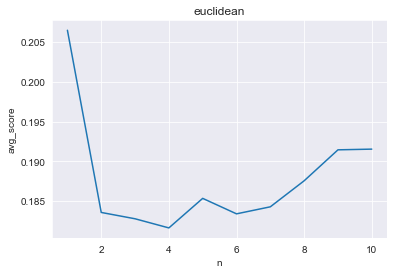

In [23]:
def best_n(X, n, metric='euclidean'):
    avg_score = []

    for i in range(n):
        clf = KNeighborsClassifier(n_neighbors=i+1, algorithm='brute', metric=metric)
        cv_result = cross_validate(clf, X, target, cv=kf)
        avg_score.append(np.average(cv_result['test_score']))
    n = np.arange(1, n+1)

    sns.set_style('darkgrid')
    plt.plot(n, avg_score)
    plt.xlabel('n')
    plt.ylabel('avg_score')
    plt.title(metric)
    plt.show()
    return np.argmax(avg_score)+1, avg_score

n_best, avg_score = best_n(X_train, 10, metric='euclidean')

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

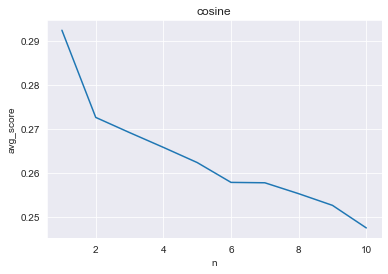

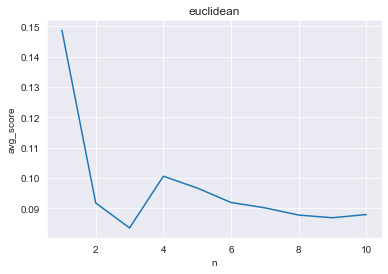

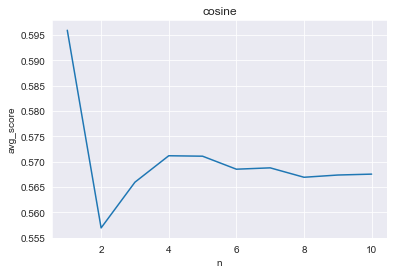

In [24]:
n_best, avg_score = best_n(X_train, n=10, metric='cosine')

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(data)
n_best, avg_score = best_n(X_train, n=10, metric='euclidean')
n_best, avg_score = best_n(X_train, n=10, metric='cosine')

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [25]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

data_test = newsgroups['data']
target_test = newsgroups['target']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)
X_test = vectorizer.transform(data_test)

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [26]:
clf = KNeighborsClassifier(n_neighbors=n_best, algorithm='brute', metric='cosine')

clf.fit(X, target)

pred = clf.predict(X_test)
accuracy_score(target_test, pred)

0.5088953797132236

Точность модели на тестовой части датасета отличается от точности для кросс-валидации. Это происходит из-за переобучения модели. Так как значение $k = 1$ мало, то модель просто запоминает данные из обучающей выборки и при её тестировании на новых данных не дает содержательных результатов. 